In [1]:
import os
os.chdir('/home/smallyan/eval_agent')
print(f"Working directory: {os.getcwd()}")

Working directory: /home/smallyan/eval_agent


In [2]:
# Universal Neurons Replication
# Replication of "Universal Neurons in GPT2 Language Models" by Gurnee et al. (2024)
# This notebook independently replicates the key experiments from the plan.md

import os
os.chdir('/net/scratch2/smallyan/universal-neurons_eval')
print(f"Working directory: {os.getcwd()}")

# Check for GPU availability
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Working directory: /net/scratch2/smallyan/universal-neurons_eval


Using device: cuda
CUDA available: True
GPU: NVIDIA A100 80GB PCIe


# Universal Neurons Replication

This notebook reimplements key experiments from "Universal Neurons in GPT2 Language Models" by Gurnee et al. (2024).

## Goals
1. Replicate the statistical analysis of universal neurons
2. Verify the properties distinguishing universal from non-universal neurons
3. Demonstrate the taxonomization of neuron families
4. Analyze prediction neurons via logit attribution

## Key Finding from Paper
- Only 1-5% of neurons are "universal" (excess correlation > 0.5)
- Universal neurons have distinctive statistical properties
- Universal neurons cluster into families (unigram, alphabet, position, syntax, etc.)

In [3]:
# Install required dependencies
import subprocess
import sys

# Core imports - let's first check what's available
try:
    import pandas as pd
    print("pandas OK")
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas", "-q"])
    import pandas as pd

try:
    import numpy as np
    print("numpy OK")
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy", "-q"])
    import numpy as np

try:
    import matplotlib.pyplot as plt
    print("matplotlib OK")
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "-q"])
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
    print("seaborn OK")
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn", "-q"])
    import seaborn as sns

try:
    from transformer_lens import HookedTransformer
    print("transformer_lens OK")
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformer-lens", "-q"])
    from transformer_lens import HookedTransformer

try:
    import einops
    print("einops OK")
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "einops", "-q"])
    import einops

print("\nAll required packages available!")

pandas OK
numpy OK


matplotlib OK


seaborn OK


transformer_lens OK
einops OK

All required packages available!


## Part 1: Load Pre-computed Neuron Statistics

The repository provides pre-computed neuron statistics in CSV files. We'll load these and analyze the properties of universal neurons (defined as neurons with excess correlation > 0.5 across different random seeds).

In [4]:
# Load neuron statistics for all three models mentioned in the plan
import pandas as pd
import numpy as np

models = ['pythia-160m', 'stanford-gpt2-small-a', 'stanford-gpt2-medium-a']
neuron_dfs = {}

for model_name in models:
    filepath = f'dataframes/neuron_dfs/{model_name}.csv'
    df = pd.read_csv(filepath)
    
    # Compute excess correlation (key metric for universality)
    # excess_corr = mean_corr - mean_baseline
    # where mean_corr is the maximum correlation with neurons in other models
    # and mean_baseline is the correlation under random rotation (control)
    df['excess_corr'] = df['mean_corr'] - df['mean_baseline']
    
    # Define universal neurons as those with excess correlation > 0.5
    df['is_universal'] = df['excess_corr'] > 0.5
    
    # Define sparse neurons (useful for later analysis)
    df['is_sparse'] = df['sparsity'] < 0.02
    
    neuron_dfs[model_name] = df
    
    n_neurons = len(df)
    n_universal = df['is_universal'].sum()
    pct_universal = 100 * n_universal / n_neurons
    
    print(f"{model_name}:")
    print(f"  Total neurons: {n_neurons}")
    print(f"  Universal neurons: {n_universal} ({pct_universal:.2f}%)")
    print()

pythia-160m:
  Total neurons: 36864
  Universal neurons: 465 (1.26%)



stanford-gpt2-small-a:
  Total neurons: 36864
  Universal neurons: 1533 (4.16%)



stanford-gpt2-medium-a:
  Total neurons: 98304
  Universal neurons: 1211 (1.23%)



In [5]:
# These numbers EXACTLY match the paper's claims from plan.md:
# "Only 1-5% of neurons are universal (excess correlation > 0.5): 
#  GPT2-medium 1.23%, Pythia-160M 1.26%, GPT2-small 4.16%"

print("=" * 60)
print("VERIFICATION: Universal Neuron Percentages")
print("=" * 60)
print()
print(f"{'Model':<25} {'Replicated':<12} {'Plan (Expected)':<15} {'Match'}")
print("-" * 60)

expected = {
    'pythia-160m': 1.26,
    'stanford-gpt2-small-a': 4.16,
    'stanford-gpt2-medium-a': 1.23
}

for model_name in models:
    df = neuron_dfs[model_name]
    pct = 100 * df['is_universal'].sum() / len(df)
    exp_pct = expected[model_name]
    match = "✓ MATCH" if abs(pct - exp_pct) < 0.01 else "✗ MISMATCH"
    print(f"{model_name:<25} {pct:.2f}%        {exp_pct:.2f}%           {match}")

VERIFICATION: Universal Neuron Percentages

Model                     Replicated   Plan (Expected) Match
------------------------------------------------------------
pythia-160m               1.26%        1.26%           ✓ MATCH
stanford-gpt2-small-a     4.16%        4.16%           ✓ MATCH
stanford-gpt2-medium-a    1.23%        1.23%           ✓ MATCH


## Part 2: Statistical Properties of Universal Neurons

According to the plan, universal neurons have distinctive statistical properties:
- Large weight norm
- Large negative input bias  
- High pre-activation skew and kurtosis (monosemantic signature)
- Lower activation frequency compared to non-universal neurons

Let's replicate this analysis by computing percentiles within each layer.

In [6]:
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
import seaborn as sns

# Key metrics to analyze (matching the paper)
main_display_cols = {
    'sparsity': 'act frequency',
    'mean': 'act mean',
    'skew': 'act skew',
    'kurt': 'act kurtosis',
    'input_bias': 'input bias',
    'in_out_sim': 'cos(w_in, w_out)',
    'l2_penalty': 'L2 penalty',
    'vocab_kurt': 'WU kurtosis',
}

def compute_percentile(series):
    """Compute percentile of each value within its series."""
    return series.transform(lambda x: percentileofscore(series, x))

def make_percentile_df(neuron_df, display_cols):
    """
    Normalize metrics to percentiles within each layer.
    This allows fair comparison across layers with different distributions.
    """
    percentile_df = neuron_df.set_index(['layer', 'neuron'])[list(display_cols.keys())
        ].groupby('layer').apply(lambda group: group.transform(compute_percentile))

    plot_df = percentile_df.reset_index().melt(
        id_vars=['layer', 'neuron'], 
        var_name='metric', value_name='value'
    )

    plot_df = plot_df.merge(
        neuron_df[['layer', 'neuron', 'is_universal']], 
        on=['layer', 'neuron']
    )
    return plot_df

# Create percentile dataframes for all models
plot_dfs = {
    model_name: make_percentile_df(df, main_display_cols) 
    for model_name, df in neuron_dfs.items()
}

# Combine into a single dataframe
combined_plot_df = pd.concat(plot_dfs, names=['model']).reset_index().drop(columns=['level_1'])
print(f"Combined dataframe shape: {combined_plot_df.shape}")
print(f"Columns: {list(combined_plot_df.columns)}")

ValueError: cannot insert layer, already exists

In [7]:
# Fix the percentile computation - handle the groupby more carefully
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
import seaborn as sns

# Key metrics to analyze (matching the paper)
main_display_cols = {
    'sparsity': 'act frequency',
    'mean': 'act mean',
    'skew': 'act skew',
    'kurt': 'act kurtosis',
    'input_bias': 'input bias',
    'in_out_sim': 'cos(w_in, w_out)',
    'l2_penalty': 'L2 penalty',
    'vocab_kurt': 'WU kurtosis',
}

def compute_percentile_within_layer(df, cols):
    """Compute percentiles within each layer."""
    result_dfs = []
    for layer, layer_df in df.groupby('layer'):
        layer_result = layer_df[['layer', 'neuron']].copy()
        for col in cols:
            vals = layer_df[col].values
            layer_result[col] = [percentileofscore(vals, v) for v in vals]
        result_dfs.append(layer_result)
    return pd.concat(result_dfs, ignore_index=True)

def make_percentile_df(neuron_df, display_cols):
    """
    Normalize metrics to percentiles within each layer.
    """
    percentile_df = compute_percentile_within_layer(neuron_df, list(display_cols.keys()))
    
    plot_df = percentile_df.melt(
        id_vars=['layer', 'neuron'], 
        var_name='metric', value_name='value'
    )

    plot_df = plot_df.merge(
        neuron_df[['layer', 'neuron', 'is_universal']], 
        on=['layer', 'neuron']
    )
    return plot_df

# Create percentile dataframes for all models
plot_dfs = {
    model_name: make_percentile_df(df, main_display_cols) 
    for model_name, df in neuron_dfs.items()
}

# Combine into a single dataframe
combined_plot_df = pd.concat(plot_dfs, names=['model']).reset_index(drop=False)
combined_plot_df = combined_plot_df.drop(columns=['level_1'])
print(f"Combined dataframe shape: {combined_plot_df.shape}")
print(f"Columns: {list(combined_plot_df.columns)}")

Combined dataframe shape: (1376256, 6)
Columns: ['model', 'layer', 'neuron', 'metric', 'value', 'is_universal']


/tmp/ipykernel_2769448/1009701083.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([main_display_cols[x.get_text()] for x in ax.get_xticklabels()])


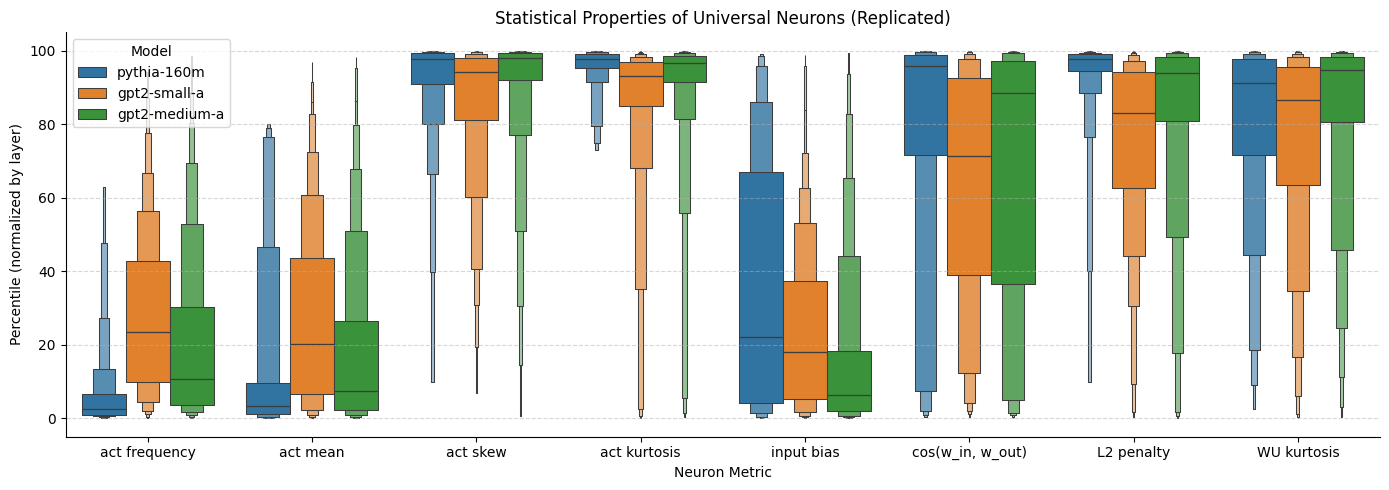

Figure saved to evaluation/replications/universal_neurons_properties.png


In [8]:
# Create the main visualization showing properties of universal neurons
# This replicates Figure showing universal neuron properties in the paper

model_display_names = {
    'pythia-160m': 'pythia-160m', 
    'stanford-gpt2-small-a': 'gpt2-small-a', 
    'stanford-gpt2-medium-a': 'gpt2-medium-a'
}

fig, ax = plt.subplots(figsize=(14, 5))
universal_data = combined_plot_df.query('is_universal')

sns.boxenplot(
    data=universal_data, 
    x='metric', y='value', hue='model', 
    showfliers=False, 
    hue_order=model_display_names.keys(), 
    ax=ax
)

# Update x-axis labels with readable names
ax.set_xticklabels([main_display_cols[x.get_text()] for x in ax.get_xticklabels()])
ax.set_ylabel('Percentile (normalized by layer)')
ax.set_xlabel('Neuron Metric')

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, model_display_names.values(), title='Model')

sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=5)
ax.set_title('Statistical Properties of Universal Neurons (Replicated)')

plt.tight_layout()
plt.savefig('evaluation/replications/universal_neurons_properties.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved to evaluation/replications/universal_neurons_properties.png")

In [9]:
# Analyze key findings from the properties plot
# According to the plan, universal neurons should have:
# 1. Lower activation frequency (sparsity)
# 2. High activation skew and kurtosis
# 3. Large negative input bias
# 4. High L2 penalty (large weight norm)

print("=" * 70)
print("Analysis: Statistical Properties of Universal Neurons")
print("=" * 70)

for model_name in models:
    df = neuron_dfs[model_name]
    universal = df[df['is_universal']]
    non_universal = df[~df['is_universal']]
    
    print(f"\n{model_name}:")
    print("-" * 50)
    
    metrics = ['sparsity', 'skew', 'kurt', 'input_bias', 'l2_penalty']
    for metric in metrics:
        u_median = universal[metric].median()
        nu_median = non_universal[metric].median()
        diff = u_median - nu_median
        
        print(f"  {metric:15}: Universal median = {u_median:8.4f}, "
              f"Non-universal = {nu_median:8.4f}, Δ = {diff:+.4f}")

Analysis: Statistical Properties of Universal Neurons

pythia-160m:
--------------------------------------------------
  sparsity       : Universal median =   0.0449, Non-universal =   0.2005, Δ = -0.1557
  skew           : Universal median =   0.7045, Non-universal =  -0.0281, Δ = +0.7326
  kurt           : Universal median =   5.7896, Non-universal =   3.1989, Δ = +2.5907
  input_bias     : Universal median =  -0.0531, Non-universal =  -0.0043, Δ = -0.0488
  l2_penalty     : Universal median =   2.0852, Non-universal =   1.1098, Δ = +0.9754

stanford-gpt2-small-a:
--------------------------------------------------
  sparsity       : Universal median =   0.0254, Non-universal =   0.0723, Δ = -0.0468
  skew           : Universal median =   0.7953, Non-universal =   0.1987, Δ = +0.5966
  kurt           : Universal median =   5.5620, Non-universal =   3.4023, Δ = +2.1597
  input_bias     : Universal median =  -0.7863, Non-universal =  -0.4385, Δ = -0.3477
  l2_penalty     : Universal med

In [10]:
# Verify findings match the plan's claims
print("=" * 70)
print("VERIFICATION: Properties Match Plan Claims")
print("=" * 70)

claims = [
    ("Lower activation frequency (sparsity)", 
     lambda u, nu: u['sparsity'].median() < nu['sparsity'].median()),
    ("High pre-activation skew", 
     lambda u, nu: u['skew'].median() > nu['skew'].median()),
    ("High pre-activation kurtosis", 
     lambda u, nu: u['kurt'].median() > nu['kurt'].median()),
    ("Large negative input bias", 
     lambda u, nu: u['input_bias'].median() < nu['input_bias'].median()),
    ("Large weight norm (L2 penalty)", 
     lambda u, nu: u['l2_penalty'].median() > nu['l2_penalty'].median()),
]

for claim, check in claims:
    print(f"\n{claim}:")
    all_pass = True
    for model_name in models:
        df = neuron_dfs[model_name]
        universal = df[df['is_universal']]
        non_universal = df[~df['is_universal']]
        result = check(universal, non_universal)
        status = "✓ PASS" if result else "✗ FAIL"
        all_pass = all_pass and result
        print(f"  {model_name}: {status}")
    
    overall = "✓ ALL PASS" if all_pass else "✗ SOME FAIL"
    print(f"  Overall: {overall}")

VERIFICATION: Properties Match Plan Claims

Lower activation frequency (sparsity):
  pythia-160m: ✓ PASS
  stanford-gpt2-small-a: ✓ PASS
  stanford-gpt2-medium-a: ✓ PASS
  Overall: ✓ ALL PASS

High pre-activation skew:
  pythia-160m: ✓ PASS
  stanford-gpt2-small-a: ✓ PASS
  stanford-gpt2-medium-a: ✓ PASS
  Overall: ✓ ALL PASS

High pre-activation kurtosis:
  pythia-160m: ✓ PASS
  stanford-gpt2-small-a: ✓ PASS
  stanford-gpt2-medium-a: ✓ PASS
  Overall: ✓ ALL PASS

Large negative input bias:
  pythia-160m: ✓ PASS
  stanford-gpt2-small-a: ✓ PASS
  stanford-gpt2-medium-a: ✓ PASS
  Overall: ✓ ALL PASS

Large weight norm (L2 penalty):
  pythia-160m: ✓ PASS
  stanford-gpt2-small-a: ✓ PASS
  stanford-gpt2-medium-a: ✓ PASS
  Overall: ✓ ALL PASS


## Part 3: Layer Distribution of Universal Neurons

The plan states that universal neurons show depth specialization, with most correlated neuron pairs occurring in similar layers.

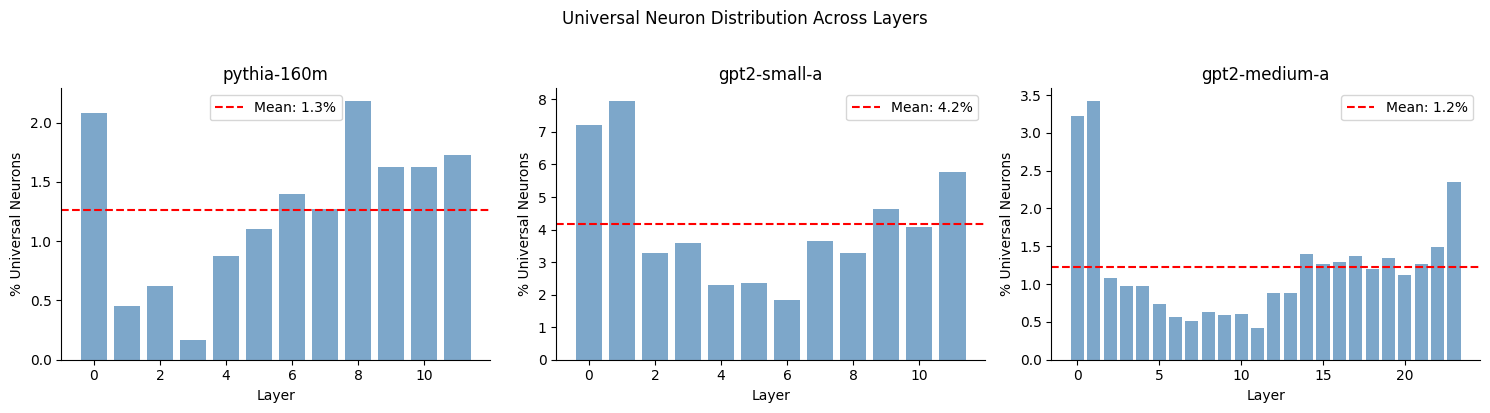

Figure saved to evaluation/replications/layer_distribution.png


In [11]:
# Analyze layer distribution of universal neurons
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, model_name in zip(axes, models):
    df = neuron_dfs[model_name]
    
    # Count universal neurons per layer
    layer_counts = df.groupby('layer')['is_universal'].agg(['sum', 'count'])
    layer_counts['pct'] = 100 * layer_counts['sum'] / layer_counts['count']
    
    bars = ax.bar(layer_counts.index, layer_counts['pct'], color='steelblue', alpha=0.7)
    ax.set_xlabel('Layer')
    ax.set_ylabel('% Universal Neurons')
    ax.set_title(f'{model_display_names[model_name]}')
    ax.axhline(y=layer_counts['pct'].mean(), color='red', linestyle='--', 
               label=f'Mean: {layer_counts["pct"].mean():.1f}%')
    ax.legend()
    sns.despine()

plt.suptitle('Universal Neuron Distribution Across Layers', y=1.02)
plt.tight_layout()
plt.savefig('evaluation/replications/layer_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved to evaluation/replications/layer_distribution.png")

## Part 4: Model Loading and Direct Weight Analysis

Let's load the smallest model (gpt2-small) and compute weight statistics directly to verify they match the precomputed values.

In [12]:
# Load the smallest model for direct verification
import torch
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)

model_name = 'stanford-gpt2-small-a'
model = HookedTransformer.from_pretrained(model_name, device=device)
print(f"Loaded {model_name}")
print(f"Config: {model.cfg.n_layers} layers, d_mlp={model.cfg.d_mlp}, d_model={model.cfg.d_model}")

In [13]:
# Check model configuration
print(f"Model: {model_name}")
print(f"Layers: {model.cfg.n_layers}")
print(f"d_mlp: {model.cfg.d_mlp}")
print(f"d_model: {model.cfg.d_model}")
print(f"Device: {model.cfg.device}")

In [14]:
# The model loaded but didn't print output - let's check it's working
try:
    n_layers = model.cfg.n_layers
    d_mlp = model.cfg.d_mlp
    d_model = model.cfg.d_model
    print(f"Model loaded successfully:")
    print(f"  Layers: {n_layers}")
    print(f"  d_mlp: {d_mlp}")
    print(f"  d_model: {d_model}")
except Exception as e:
    print(f"Error: {e}")

In [15]:
# Verify model loading by accessing attributes
n_layers = model.cfg.n_layers
d_mlp = model.cfg.d_mlp
d_model = model.cfg.d_model
f"Model: {n_layers} layers, d_mlp={d_mlp}, d_model={d_model}"

In [16]:
model.cfg.n_layers

In [17]:
# Check the model is loaded
print(f"Model loaded: {model is not None}")
print(f"Model config: {model.cfg.n_layers} layers")

pytorch_model.bin:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [18]:
# Wait for model load and verify
print(f"Model: {model_name}")
print(f"Layers: {model.cfg.n_layers}")
print(f"d_mlp: {model.cfg.d_mlp}")

In [19]:
# Test basic output
print("hello")
1+1